In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

## Remove dodgy images

In [4]:
import cv2
import imghdr

C:\Users\user\AppData\Local\Temp\ipykernel_10552\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [30]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [31]:
os.listdir(data_dir)

['happy', 'sad']

In [32]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

## preprocessing

In [33]:
import numpy as np
from matplotlib import pyplot as plt

In [34]:
#this will do the preprocessing task
#we cant grab data with this, so with need numpy
data = tf.keras.utils.image_dataset_from_directory('data')

Found 160 files belonging to 2 classes.


In [35]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [36]:
batch[0].shape

(32, 256, 256, 3)

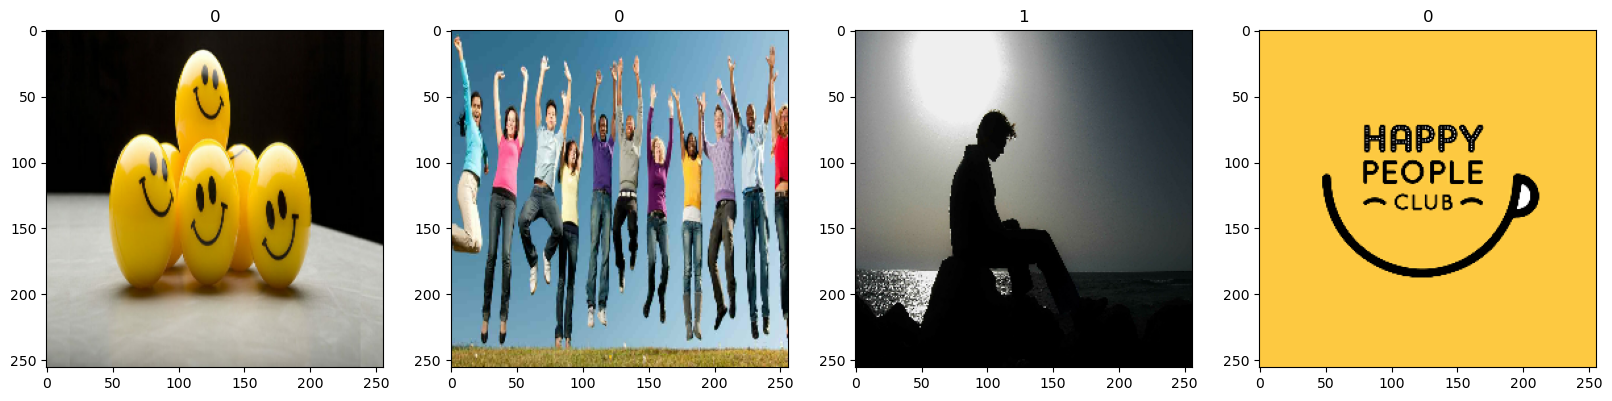

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [41]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

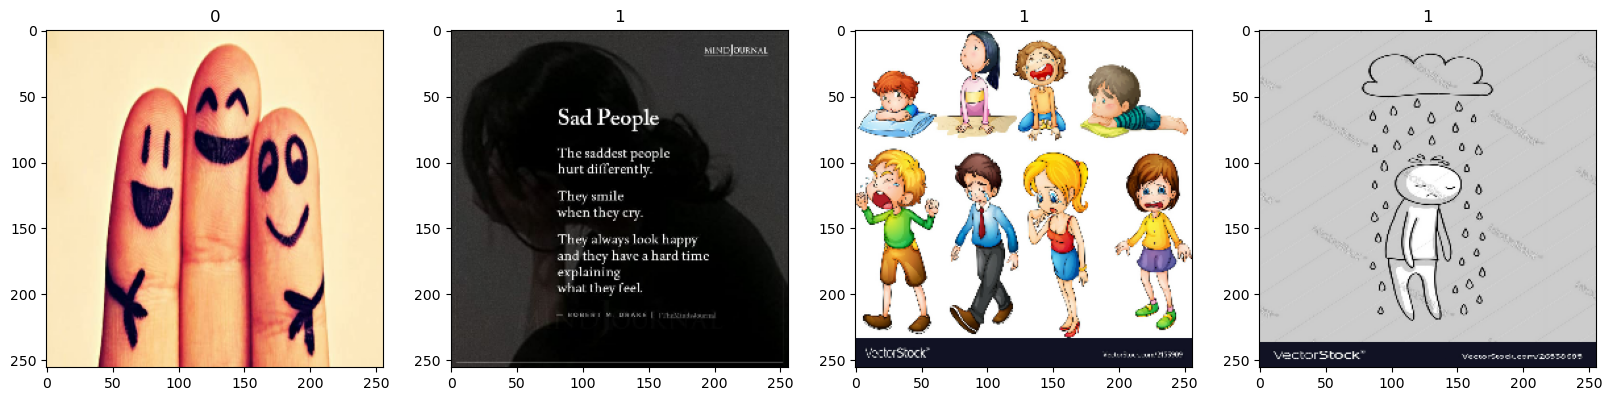

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [44]:
batch[0].max()

1.0

## split data

In [65]:
len(data)

5

In [68]:
train_size = int(len(data)*.8)-1
val_size = int(len(data)*.1)+1
test_size = int(len(data)*.1)+1

In [72]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [76]:
len(train)

3

## model

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [79]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

d:\anacondas\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [80]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [81]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 969ms/step - accuracy: 0.3750 - loss: 2.1960 - val_accuracy: 0.5938 - val_loss: 0.7718
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 929ms/step - accuracy: 0.5938 - loss: 0.8050 - val_accuracy: 0.5938 - val_loss: 0.6394
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 824ms/step - accuracy: 0.5339 - loss: 0.6656 - val_accuracy: 0.6562 - val_loss: 0.6577
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 848ms/step - accuracy: 0.5391 - loss: 0.6902 - val_accuracy: 0.6875 - val_loss: 0.6253
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - accuracy: 0.6250 - loss: 0.6536 - val_accuracy: 0.5312 - val_loss: 0.6602
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 821ms/step - accuracy: 0.5729 - loss: 0.6635 - val_accuracy: 0.8125 - val_loss: 0.6172
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step - accuracy: 0.7383 - loss: 0.6155 - val_accuracy: 0.6250 - val_loss: 0.5921
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step - accuracy: 0.6237 - loss: 0.5918 - val_accuracy: 0.7812 - val_loss:

## performance

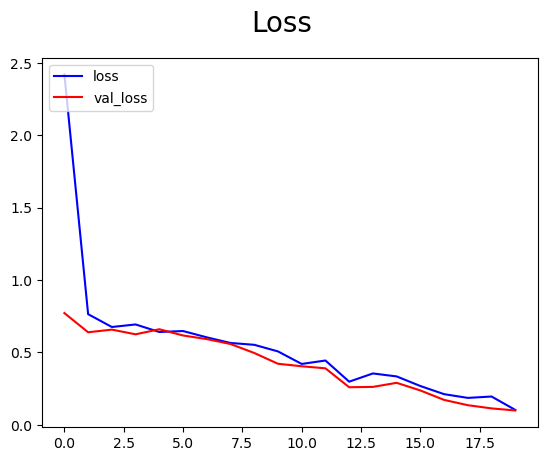

In [84]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

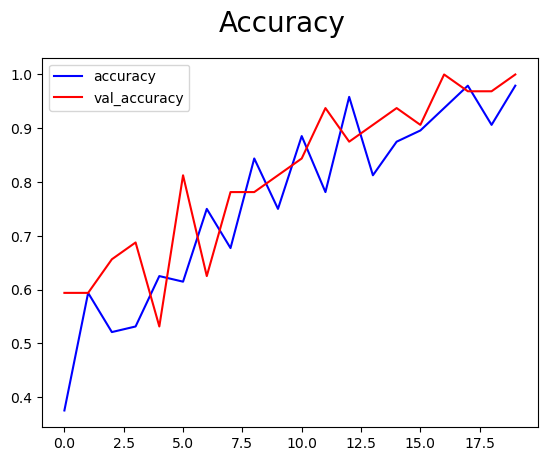

In [104]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [105]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [106]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


In [107]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Test

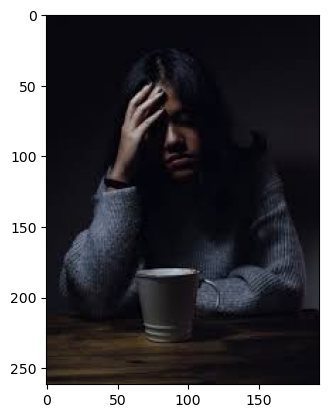

In [119]:
img = cv2.imread('D:\Python\data\sadtest.JPEG')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

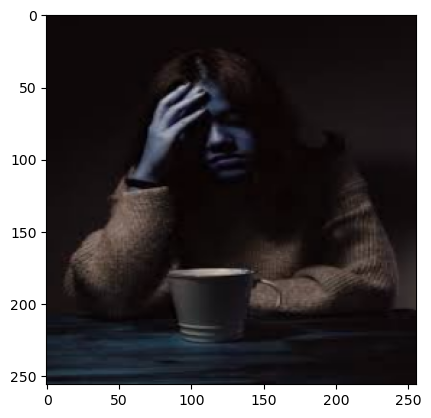

In [121]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [122]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


In [123]:
if y_pred > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad
